<h1><center>This Notebook Contains Sunspot prediction using CNN_LSTM</center></h1>

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import csv

In [2]:
time_step = []
temps = []
with open('./daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)

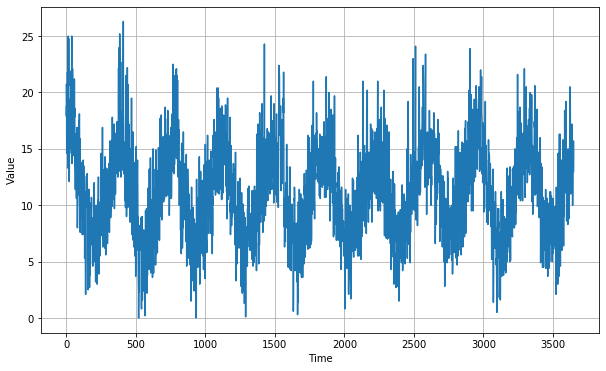

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [9]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 13s 1s/step - loss: 274.1029 - mae: 274.6985
Epoch 2/100
10/10 [==============================] - 1s 60ms/step - loss: 265.0876 - mae: 265.3651
Epoch 3/100
10/10 [==============================] - 1s 57ms/step - loss: 251.1609 - mae: 251.2643
Epoch 4/100
10/10 [==============================] - 1s 59ms/step - loss: 234.3319 - mae: 234.4304
Epoch 5/100
10/10 [==============================] - 1s 58ms/step - loss: 215.5490 - mae: 215.5794
Epoch 6/100
10/10 [==============================] - 1s 59ms/step - loss: 195.4602 - mae: 195.4939
Epoch 7/100
10/10 [==============================] - 1s 58ms/step - loss: 174.7941 - mae: 174.7544
Epoch 8/100
10/10 [==============================] - 1s 58ms/step - loss: 152.8072 - mae: 152.7361
Epoch 9/100
10/10 [==============================] - 1s 58ms/step - loss: 131.6288 - mae: 131.7107
Epoch 10/100
10/10 [==============================] - 1s 58ms/step - loss: 115.0653 - mae: 115.2067
Epoch 11/1

10/10 [==============================] - 1s 66ms/step - loss: 12.9669 - mae: 13.3331
Epoch 86/100
10/10 [==============================] - 1s 91ms/step - loss: 14.0831 - mae: 14.7561
Epoch 87/100
10/10 [==============================] - 1s 69ms/step - loss: 16.0823 - mae: 16.6033
Epoch 88/100
10/10 [==============================] - 1s 63ms/step - loss: 18.1009 - mae: 18.7340
Epoch 89/100
10/10 [==============================] - 1s 60ms/step - loss: 20.3171 - mae: 20.8735
Epoch 90/100
10/10 [==============================] - 1s 62ms/step - loss: 22.8762 - mae: 23.5225
Epoch 91/100
10/10 [==============================] - 1s 60ms/step - loss: 25.8041 - mae: 26.3914
Epoch 92/100
10/10 [==============================] - 1s 59ms/step - loss: 28.9324 - mae: 29.5941
Epoch 93/100
10/10 [==============================] - 1s 59ms/step - loss: 32.7000 - mae: 33.3192
Epoch 94/100
10/10 [==============================] - 1s 78ms/step - loss: 36.6754 - mae: 37.3776
Epoch 95/100
10/10 [=============

[1e-08, 0.0001, 0, 60]

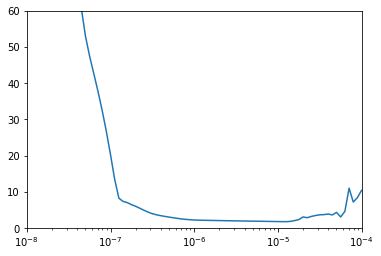

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [13]:
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 5s 196ms/step - loss: 9.9623 - mae: 10.5788
Epoch 2/150
25/25 [==============================] - 1s 34ms/step - loss: 2.5936 - mae: 3.0496
Epoch 3/150
25/25 [==============================] - 1s 28ms/step - loss: 1.9328 - mae: 2.3879
Epoch 4/150
25/25 [==============================] - 1s 30ms/step - loss: 1.8620 - mae: 2.3160
Epoch 5/150
25/25 [==============================] - 1s 30ms/step - loss: 1.8200 - mae: 2.2715
Epoch 6/150
25/25 [==============================] - 1s 30ms/step - loss: 1.7917 - mae: 2.2419
Epoch 7/150
25/25 [==============================] - 1s 30ms/step - loss: 1.7631 - mae: 2.2129
Epoch 8/150
25/25 [==============================] - 1s 31ms/step - loss: 1.7460 - mae: 2.1938
Epoch 9/150
25/25 [==============================] - 1s 32ms/step - loss: 1.7219 - mae: 2.1688
Epoch 10/150
25/25 [==============================] - 1s 37ms/step - loss: 1.7014 - mae: 2.1483
Epoch 11/150
25/25 [===========================

25/25 [==============================] - 1s 28ms/step - loss: 1.5049 - mae: 1.9456
Epoch 87/150
25/25 [==============================] - 1s 29ms/step - loss: 1.5037 - mae: 1.9447
Epoch 88/150
25/25 [==============================] - 1s 28ms/step - loss: 1.5043 - mae: 1.9458
Epoch 89/150
25/25 [==============================] - 1s 34ms/step - loss: 1.5034 - mae: 1.9436
Epoch 90/150
25/25 [==============================] - 1s 32ms/step - loss: 1.5016 - mae: 1.9430
Epoch 91/150
25/25 [==============================] - 1s 34ms/step - loss: 1.5037 - mae: 1.9444
Epoch 92/150
25/25 [==============================] - 1s 32ms/step - loss: 1.5033 - mae: 1.9440
Epoch 93/150
25/25 [==============================] - 1s 31ms/step - loss: 1.5008 - mae: 1.9414
Epoch 94/150
25/25 [==============================] - 1s 32ms/step - loss: 1.4992 - mae: 1.9398
Epoch 95/150
25/25 [==============================] - 1s 31ms/step - loss: 1.4976 - mae: 1.9380
Epoch 96/150
25/25 [==============================] -

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

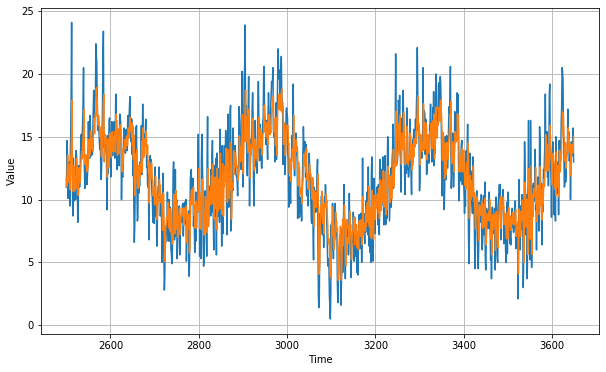

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)